In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 加载数据集
df = pd.read_csv('test_sentiment.csv')
# 检查数据类型和缺失值情况
print('数据基本信息：')
df.info()

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   sentiment  2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB


In [5]:
# 计算消息长度
df['message_length'] = df['body'].str.len()

In [6]:
# 计算单词数量
df['word_count'] = df['body'].apply(lambda x: len(x.split()))

In [7]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [8]:
# 按年月和发送者分组，计算每月的消息发送频率、平均消息长度和平均单词数量
monthly_features = df.groupby([df['date'].dt.to_period('M'), 'from']).agg(
    message_frequency=('body', 'count'),
    average_message_length=('message_length', 'mean'),
    average_word_count=('word_count', 'mean')
).reset_index()

In [9]:
# 为每条消息分配一个分数
df['score'] = df['sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

In [10]:
# 按年月和发送者分组，计算每月的情绪评分
monthly_score = df.groupby([df['date'].dt.to_period('M'), 'from'])['score'].sum().reset_index()

In [11]:
# 合并每月的情绪评分和特征
monthly_data = pd.merge(monthly_score, monthly_features, on=['date', 'from'])

In [12]:
# 准备特征和目标变量
X = monthly_data[['message_frequency', 'average_message_length', 'average_word_count']]
y = monthly_data['score']

In [13]:
# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 开发线性回归模型
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [15]:
# 在测试集上进行预测
y_pred = model.predict(X_test)

In [16]:
# 计算模型性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [17]:
# 输出模型性能指标和系数
print('均方误差：', mse)
print('决定系数：', r2)
print('模型系数：', model.coef_)

均方误差： 2.415370160330918
决定系数： 0.7027077915806168
模型系数： [ 0.32457842 -0.00074327  0.01909806]


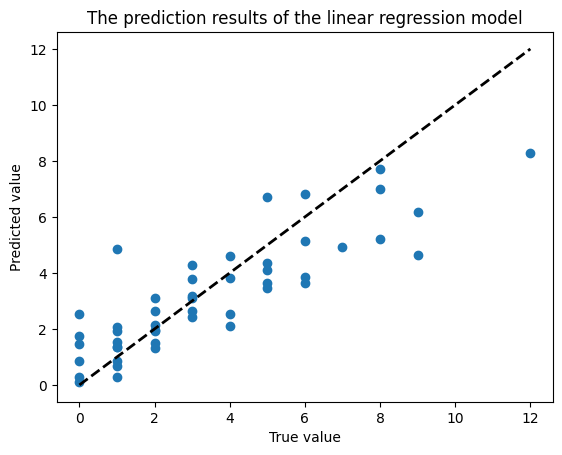

In [18]:
# 绘制预测值和真实值的散点图
plt.scatter(y_test, y_pred)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('The prediction results of the linear regression model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

# 线性回归模型效果总结  

### 1. 核心评估指标分析  
| 指标          | 数值          | 含义解读                                                                 |  
|---------------|---------------|--------------------------------------------------------------------------|  
| **均方误差（MSE）** | `2.415`       | 预测值与真实值的平均平方偏差，值越小精度越高。此处误差适中，存在优化空间。       |  
| **决定系数（R²）**   | `0.702`       | 模型解释了约 **70.2%** 的情绪评分变异，拟合效果较好，但仍有近30%变异未被捕捉。 |  


### 2. 特征影响解析  
模型系数揭示输入特征对情绪评分的影响方向与强度：  
- **消息发送频率（`message_frequency`）**：系数 `0.325`（**正向**）  
  员工每月发送消息越多，情绪评分越高（积极倾向更明显），是核心影响因素。  
- **平均消息长度（`average_message_length`）**：系数 `-0.0007`（**近零，负向**）  
  对情绪评分的影响极微弱，几乎可忽略。  
- **平均单词数量（`average_word_count`）**：系数 `0.0191`（**正向**）  
  消息词数越多，情绪评分略高，但影响幅度远小于“消息发送频率”。  


### 3. 可视化验证（预测值 vs 真实值散点图）  
散点图呈现以下特征：  
- **整体趋势**：数据点大致沿对角线分布，说明模型能捕捉情绪评分的整体变化规律。  
- **误差体现**：部分点偏离对角线较远，印证MSE反映的“预测存在误差”结论。  




### 综合结论  
该模型对员工情绪评分有一定预测能力（R²≈0.7），但仍需优化：  
- **优势**：明确 **“消息发送频率与积极情绪的正相关关系”**，为员工参与度分析提供依据。  
- **不足**：未解释的30%变异需通过 **拓展特征**（如消息主题、互动频率、部门属性）或 **换用非线性模型**（随机森林、XGBoost）弥补。  

后续可围绕 **“高频沟通员工的积极倾向”** 深入分析，结合业务场景挖掘情绪驱动因素。